# **Imports**

In [ ]:
!pip install duckduckpy
!pip install -Uqq fastai fastbook nbdev


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
bs = 8 # batch size

In [ ]:
from fastai import *
from fastbook import *
from fastai.vision.all import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/MasterCourse Data Science/P02_Food_Classifier/
data_path = "data"
import os

model_path = "model"

# Check if the directory exists, and if not, create it
if not os.path.exists(model_path):
    os.makedirs(model_path)
    print(f"Directory '{model_path}' created.")
else:
    print(f"Directory '{model_path}' already exists.")


/content/drive/My Drive/Colab Notebooks/MasterCourse Data Science/P02_Food_Classifier
Directory 'model' already exists.


In [ ]:
doc(download_images)

# Scrap Data using DuckDuckGo

`Do note there's limitation of how many data you can pull in each call `
`Make multiple calls in spaced time interval to collect 1000+ data for each class`




In [ ]:

# List of cuisines and their popular dishes
cuisines = {
    'Italian': ['pizza', 'speggeti', 'lasagna'],
    'Japanese': ['sushi', 'ramen', 'okonomiyaki'],
    'Indian': ['biriyani', 'samosa', 'khichuri'],
    'Mexican': ['tacos', 'nachos','Chilaquiles'],
    'Turkish': ['kebab', 'baklava', 'meze_food','swarma'],
    'American': ['burger', 'fried chicken', 'hot dog']
}

data_path = "data"
if not os.path.exists(data_path):
    os.mkdir(data_path)

# Loop through each cuisine and its dishes
for cuisine, dishes in cuisines.items():
    # Create a directory for each cuisine
    cuisine_path = f"{data_path}/{cuisine.replace(' ', '_')}"  # Replace spaces with underscores
    if not os.path.exists(cuisine_path):
        os.mkdir(cuisine_path)  # Create cuisine directory

    for dish in dishes:
        # Create a directory for each dish within the cuisine
        dish_path = f"{cuisine_path}/{dish.replace(' ', '_')}"  # Replace spaces with underscores
        if not os.path.exists(dish_path):
            os.mkdir(dish_path)  # Create dish directory

        try:
            # Search for food images
            food_urls = search_images_ddg(dish, max_images=420)

            # Download images into the respective folder
            download_images(dest=dish_path, urls=food_urls, max_pics=420)
            print(f"Downloaded {len(food_urls)} images for {dish} in {cuisine}")

        except Exception as e:
            print(f"Error downloading images for {dish} in {cuisine}: {e}")
            continue


In [ ]:
doc(get_image_files)

In [ ]:
image_counts = get_image_files(data_path)
image_counts

(#13084) [Path('data/Italian/pizza/d282c0e8-49e4-4922-89f1-a9da83e7a548.jpg'),Path('data/Italian/pizza/da31ebea-1733-46d5-8574-4bbce4866fa0.jpg'),Path('data/Italian/pizza/24421edb-1a5a-4091-81da-0327c1ccb82b.png'),Path('data/Italian/pizza/7410909b-1abf-4457-9971-f6cdb2a2046d.jpeg'),Path('data/Italian/pizza/c084f05d-a909-4fec-9262-083539a34849.jpg'),Path('data/Italian/pizza/64fac4b2-f17e-4c26-82c1-78c441040c42.jpeg'),Path('data/Italian/pizza/e4655ee5-baf6-4457-bbc2-4f47ef21ee25.jpg'),Path('data/Italian/pizza/6feb5df5-ba46-4549-ae95-3dcb30ccba86.jpg'),Path('data/Italian/pizza/4eee48ff-fb72-4468-811e-8ab63c0311af.png'),Path('data/Italian/pizza/f651cae8-a81b-497f-98a9-c76125d3f8ae.jpg')...]

In [ ]:
failed = verify_images(image_counts)
failed

(#421) [Path('data/Italian/pizza/e56e322c-4ec9-4e54-9a31-35179d69bb72.jpg'),Path('data/Italian/pizza/05be7cdb-e5e2-4719-b5a2-48e4ddf72565.jpg'),Path('data/Italian/pizza/decc1a9b-a9f7-44ad-aab7-723eb36731eb.jpg'),Path('data/Italian/pizza/00920197-799d-4f83-9c35-008711eb5984.jpeg'),Path('data/Italian/pizza/18c6892e-8c13-4f41-8d67-8e06ae17e372.jpg'),Path('data/Italian/pizza/859e6c67-3cfa-441d-9e78-675a03e4ae6f.jpg'),Path('data/Italian/pizza/2f31ccee-689d-48c8-98d7-4950882ae69f.jpg'),Path('data/Italian/pizza/e3bbd377-ee6a-4917-93b8-6f599037c6ca.jpg'),Path('data/Italian/pizza/3f7efab9-9cbb-45ba-ad98-1cf344cebc24.jpg'),Path('data/Italian/pizza/764f1769-e937-4129-bdaa-b7cead146870.jpg')...]

In [ ]:
# failed.map(Path.unlink)

In [ ]:
doc(DataBlock)

In [ ]:
# Augmentation Techniques in aug_transforms:
# 1. Random Cropping: Crops the image to a random size.
# 2. Flipping: Randomly flips images horizontally (and sometimes vertically).
# 3. Rotation: Applies random rotations within a specified range.
# 4. Zooming/Scaling: Randomly zooms in or out of the images.
# 5. Color Jittering: Adjusts brightness, contrast, saturation, and hue randomly.
# 6. Gaussian Noise: Introduces random noise into the images.
# 7. Affine Transformations: Applies transformations such as translation and shearing.

from fastai.vision.all import *
from PIL import Image, UnidentifiedImageError
import os

# Allowed image extensions
valid_extensions = {'.jpeg', '.jpg', '.png'}

data_path = Path("data")

# Define a function to get both the parent (cuisine) and the folder (dish)
def get_labels(file_path):
    # Get the parent folder (cuisine) and the dish folder
    cuisine = file_path.parent.parent.name  # The top-level folder (e.g., American)
    dish = file_path.parent.name            # The sub-folder (e.g., burger)
    return f"{cuisine} {dish}"              # Combine them for a multi-label classification

# Custom function to load and convert images to RGBA
def load_image_safe(fn):
    try:
        img = Image.open(fn)
        # If the image has a palette and transparency, convert it to RGBA
        if img.mode == "P":
            img = img.convert("RGBA")
        return PILImage.create(img)
    except UnidentifiedImageError:
        print(f"Skipping corrupt image: {fn}")
        return None

# Custom function to check if an image is valid and of a valid file type
def valid_image_filter(fn):
    # Check file extension
    if not fn.suffix.lower() in valid_extensions:
        print(f"Skipping invalid file type: {fn}")
        return False

    # Check if the image can be loaded safely
    img = load_image_safe(fn)
    if img is None:
        return False
    return True

def get_valid_image(fn):
    return fn if valid_image_filter(fn) else None

def get_image_files_with_logging(path, recurse=True, folders=None):
    all_files = []
    folders = [f for f in path.iterdir() if f.is_dir()] if folders is None else folders
    for folder in folders:
        folder_files = get_image_files(folder, recurse=recurse)  # Get image files from folder
        valid_files = [f for f in folder_files if valid_image_filter(f)]  # Filter valid images
        print(f"Accessing folder: {folder.name} | Found {len(valid_files)} valid images")
        all_files += valid_files
    return all_files

data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=lambda p: get_image_files_with_logging(p),
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=get_labels,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=128),
    get_x=get_valid_image
)


# Create the DataLoader
dls = data_block.dataloaders(data_path, bs=32)

torch.save(dls, "cousine_dataloader_v1.pkl")


In [ ]:
# download the dataloader
from google.colab import files
files.download("cousine_dataloader_v1.pkl")



```
Loading the Dataloader
```



In [ ]:
from fastai.vision.all import *
from PIL import Image, UnidentifiedImageError
import os

# Allowed image extensions
valid_extensions = {'.jpeg', '.jpg', '.png'}

data_path = Path("data")

# Define a function to get both the parent (cuisine) and the folder (dish)
def get_labels(file_path):
    # Get the parent folder (cuisine) and the dish folder
    cuisine = file_path.parent.parent.name  # The top-level folder (e.g., American)
    dish = file_path.parent.name            # The sub-folder (e.g., burger)
    return f"{cuisine} {dish}"              # Combine them for a multi-label classification

# Custom function to load and convert images to RGBA
def load_image_safe(fn):
    try:
        img = Image.open(fn)
        # If the image has a palette and transparency, convert it to RGBA
        if img.mode == "P":
            img = img.convert("RGBA")
        return PILImage.create(img)
    except UnidentifiedImageError:
        print(f"Skipping corrupt image: {fn}")
        return None

# Custom function to check if an image is valid and of a valid file type
def valid_image_filter(fn):
    # Check file extension
    if not fn.suffix.lower() in valid_extensions:
        print(f"Skipping invalid file type: {fn}")
        return False

    # Check if the image can be loaded safely
    img = load_image_safe(fn)
    if img is None:
        return False
    return True


def get_valid_image(fn):
    return fn if valid_image_filter(fn) else None

# Load the DataLoaders
dls = torch.load("cousine_dataloader_v1.pkl")



<ipython-input-6-6f399c9697d4>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dls = torch.load("cousine_dataloader_v1.pkl")


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


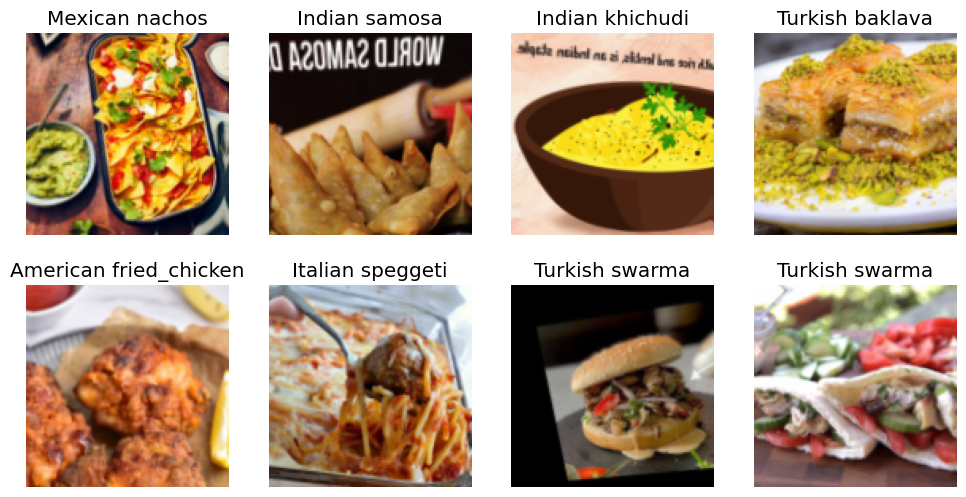

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

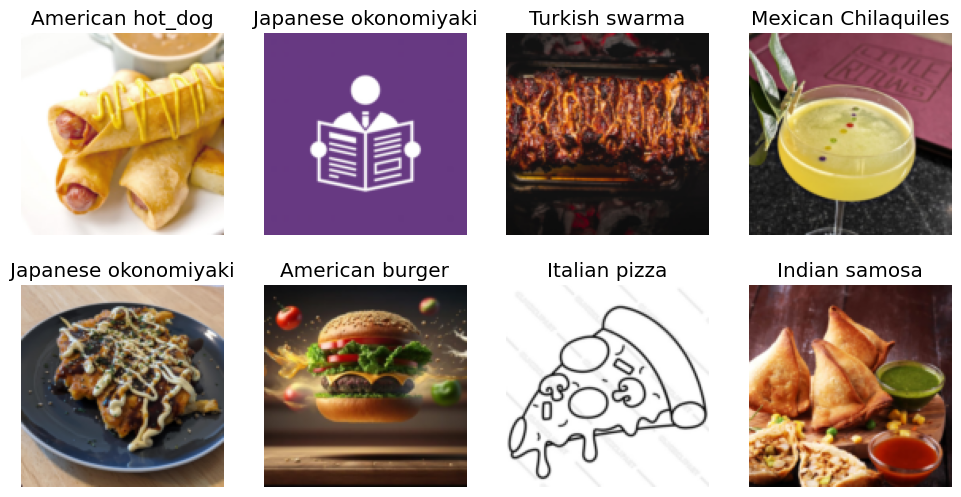

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

# Model Training


In [ ]:
model_path = "models"

In [ ]:
model = vision_learner(dls, resnet50, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.2MB/s]




```
This will plot a graph of the loss against different learning rates
```



/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0030199517495930195)

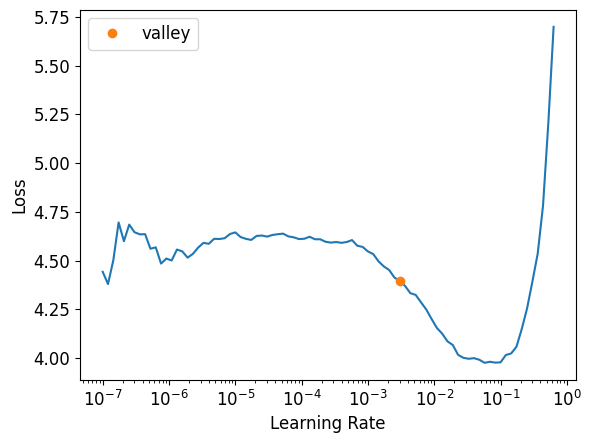

In [ ]:
model.lr_find()

In [ ]:
model_path = "models"
model = vision_learner(dls, resnet50, metrics=[error_rate,accuracy])
#model = model.to('cuda')  # Move model to GPU
dls.cuda()  # Move the data to GPU if training in GPU in colab
model.fine_tune(7, base_lr=1e-3)
model.save(model_path)



```
Observation : Looks like 10e-4 learning rate minimizes loss most

```






In [ ]:

model_path = "models"
model = vision_learner(dls, resnet50, metrics=[error_rate, accuracy])
dls.cuda()  # Move the data to GPU

# Load the model's saved state (this is a pth file)
model.load(model_path)



In [ ]:
model.fine_tune(2, base_lr=1e-3)  # Train for 2 additional epoch


epoch,train_loss,valid_loss,error_rate,accuracy,time


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
'''
Previously saved pth which only saved weights .
To use the model more freely, i'll export as pkl
'''
model.export('models.pkl')


In [ ]:
print(dls.c)  # Number of classes


21


In [ ]:
print(model.model[-1])  # Check the final layer of the model


Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=21, bias=False)
)


In [ ]:
print(dls.vocab) # importatn for building predictors
"""
['American burger', 'American fried_chicken', 'American hot_dog', 'Indian Fuchka', 'Indian biriyani', 'Indian khichudi', 'Indian khichuri', 'Indian samosa', 'Italian lasagna', 'Italian pizza', 'Italian speggeti', 'Japanese okonomiyaki', 'Japanese ramen', 'Japanese sushi', 'Mexican Chilaquiles', 'Mexican nachos', 'Mexican tacos', 'Turkish baklava', 'Turkish kebab', 'Turkish meze_food', 'Turkish swarma']

"""

['American burger', 'American fried_chicken', 'American hot_dog', 'Indian Fuchka', 'Indian biriyani', 'Indian khichudi', 'Indian khichuri', 'Indian samosa', 'Italian lasagna', 'Italian pizza', 'Italian speggeti', 'Japanese okonomiyaki', 'Japanese ramen', 'Japanese sushi', 'Mexican Chilaquiles', 'Mexican nachos', 'Mexican tacos', 'Turkish baklava', 'Turkish kebab', 'Turkish meze_food', 'Turkish swarma']


In [ ]:
model.save("model_v2")


# I am having issue in the following section , I'll figure out the issues later but still keeping it here

In [1]:
# from fastai.vision.widgets import ImageClassifierCleaner
# import os
# cleaner = ImageClassifierCleaner(model)
# cleaner

# import pickle
# from fastai.vision.widgets import ImageClassifierCleaner

# # Assuming you have your model already defined
# cleaner = ImageClassifierCleaner(model)

# # Specify the path to save the cleaner
# save_path = 'cleaner.pkl'

# # Save the cleaner using pickle
# with open(save_path, 'wb') as f:
#     pickle.dump(cleaner, f)

# print(f"Cleaner saved to {save_path}")


#Faced error
# ---------------------------------------------------------------------------

# PicklingError                             Traceback (most recent call last)

# <ipython-input-14-6f61984aad38> in <cell line: 11>()
#      10 # Save the cleaner using pickle
#      11 with open(save_path, 'wb') as f:
# ---> 12     pickle.dump(cleaner, f)
#      13
#      14 print(f"Cleaner saved to {save_path}")

# PicklingError: Can't pickle <built-in function input>: it's not the same object as builtins.input


NameError: name 'model' is not defined

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


PicklingError: Can't pickle <built-in function input>: it's not the same object as builtins.input

In [2]:
# # Load the cleaner from the saved file
# with open(save_path, 'rb') as f:
#     loaded_cleaner = pickle.load(f)

# print("Cleaner loaded successfully")


In [ ]:
# cleaner.delete()
# cleaner.change()

(#0) []

In [ ]:
# import shutil

# try:
#     for idx in cleaner.delete():
#         try:
#             cleaner.fns[idx].unlink()
#         except Exception as e:
#             print(f"Error while deleting file {cleaner.fns[idx]}: {e}")
#             continue

#     for idx, cat in cleaner.change():
#         try:
#             shutil.move(str(cleaner.fns[idx]), f"{data_path}/{cat}")
#         except Exception as e:
#             print(f"Error while moving file {cleaner.fns[idx]} to {data_path}/{cat}: {e}")
#             continue
# except Exception as e:
#     print(f"Unexpected error: {e}")

In [ ]:
# model.export('cleaned_fine_tuned_model_v2.pth') #saves just the weights


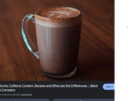

In [ ]:
# img = Image.open('cappu.png')
# img.to_thumb(128,128)

In [ ]:
# model.predict('cappu.png')

('macchiato', tensor(3), tensor([0.2145, 0.0092, 0.0090, 0.7674]))